# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# DF

For practice purposes, the iris DF it´s gonna be used to do fast test with low requirements

In [3]:
from sklearn.datasets import load_iris

In [4]:
iris = load_iris()

In [5]:
df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                 columns= iris['feature_names'] + ['target'])

In [6]:
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

# EDA

Data Analysis

In [7]:
len(df)

150

In [8]:
df.value_counts('target')

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [9]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

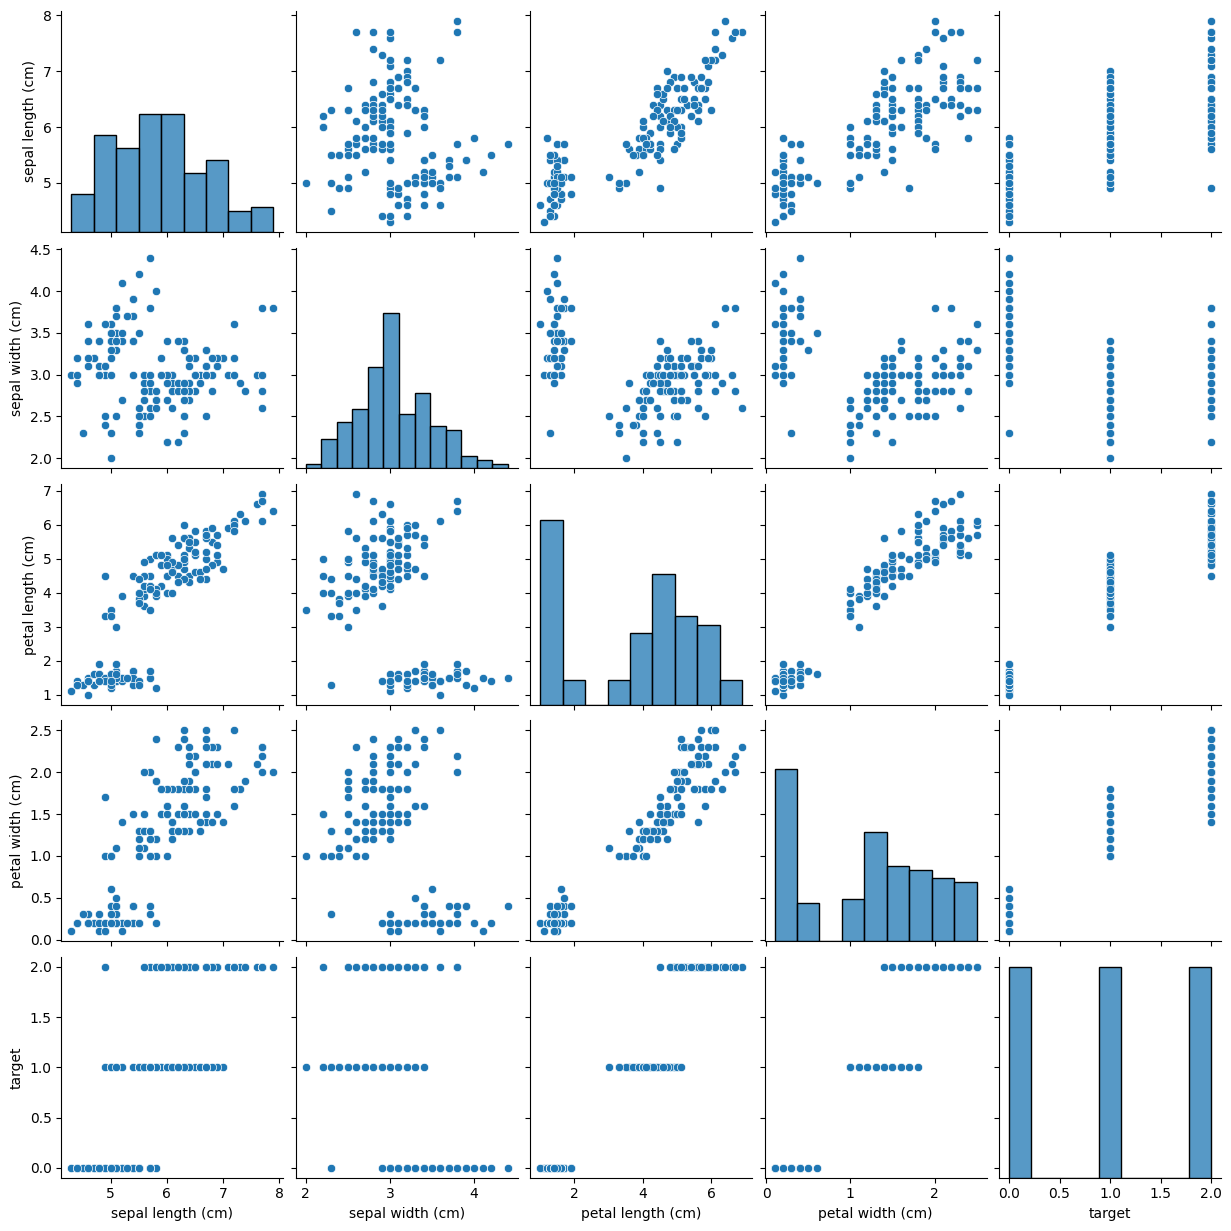

In [10]:
sns.pairplot(df)

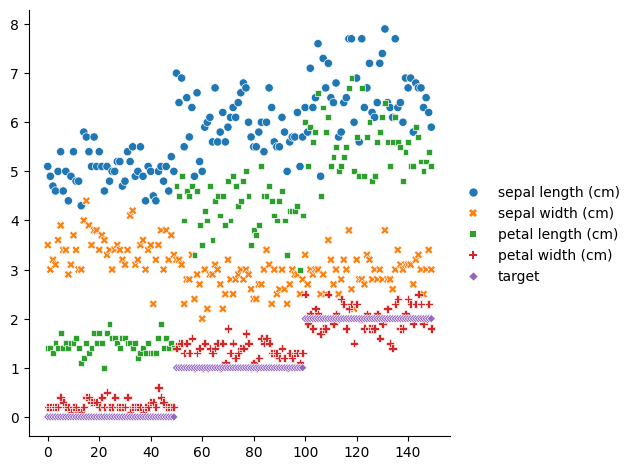

In [11]:
sns.relplot(df)

<Axes: >

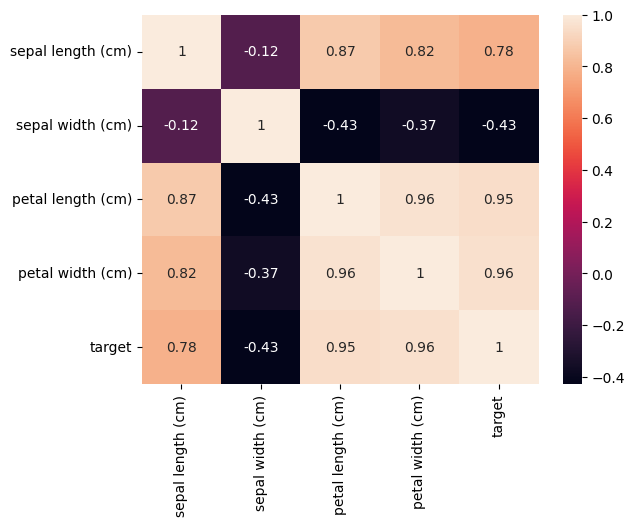

In [12]:
sns.heatmap(data=df.corr(), annot=True)

# Clasification model

In [13]:
import yaml
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

1. train /test split

In [14]:
train_df = df.drop('target', axis=1)
test_df = df[['target']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df, test_df, test_size=0.2, random_state=42)

In [40]:
val_df = X_test.join(y_test)
val_df.to_csv(r'../data/dataset/validation.csv')

2. Feature Selection

In [16]:
# Read YML parameter file

with open("parameters.yml", 'r') as file:
    # Load the YAML file
    hpo_data = yaml.safe_load(file)

In [17]:
# VIF 

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data


In [18]:
calculate_vif(df)

Feature         VIF
0  sepal length (cm)  268.296625
1   sepal width (cm)   96.466731
2  petal length (cm)  191.617053
3   petal width (cm)   71.035195
4             target   35.712253

In this case multicollinearity impacts the models, due to educational purposes I will keep it to train the model

3. Hyperparameters

In [19]:
hpo = hpo_data['logistic_regression_hpo']['hyperparameters']

In [20]:
param_grid = {
    'penalty': hpo_data['logistic_regression_hpo']['hyperparameters']['penalty']['values'],
    'dual': hpo_data['logistic_regression_hpo']['hyperparameters']['dual']['values'],
    'fit_intercept': hpo_data['logistic_regression_hpo']['hyperparameters']['fit_intercept']['values'],
    'class_weight': hpo_data['logistic_regression_hpo']['hyperparameters']['class_weight']['values'],
    'solver': hpo_data['logistic_regression_hpo']['hyperparameters']['solver']['values'],
    'max_iter': np.arange(hpo_data['logistic_regression_hpo']['hyperparameters']['max_iter']['range'][0], 
                          hpo_data['logistic_regression_hpo']['hyperparameters']['max_iter']['range'][1] + 1, 100),
    'warm_start': hpo_data['logistic_regression_hpo']['hyperparameters']['warm_start']['values'],
    'l1_ratio': np.linspace(0, 1, 5) if 'elasticnet' in hpo_data['logistic_regression_hpo']['hyperparameters']['penalty']['values'] else [None]
}

4. Model train

In [21]:
grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    verbose=1,
    scoring='accuracy'
)

In [22]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': ['None', 'balanced'],
                         'dual': [False, True], 'fit_intercept': [True, False],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'max_iter': array([ 50, 150, 250, 350, 450]),
                         'penalty': ['l2', 'none', 'l1', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'warm_start': [False, True]},
             scoring='accuracy', verbose=1)

In [23]:
grid.best_params_

{'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'max_iter': 50,
 'penalty': 'l2',
 'solver': 'sag',
 'warm_start': False}

In [24]:
y_pred = grid.predict(X_test)

5. Model metrics

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
grid.best_score_

0.975

In [27]:
accuracy_score(y_true=y_test, y_pred=y_pred)

1.0

In [28]:
classification_report(y_pred=y_pred, y_true=y_test)

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00        10\n         1.0       1.00      1.00      1.00         9\n         2.0       1.00      1.00      1.00        11\n\n    accuracy                           1.00        30\n   macro avg       1.00      1.00      1.00        30\nweighted avg       1.00      1.00      1.00        30\n'

In [29]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]])

<Axes: >

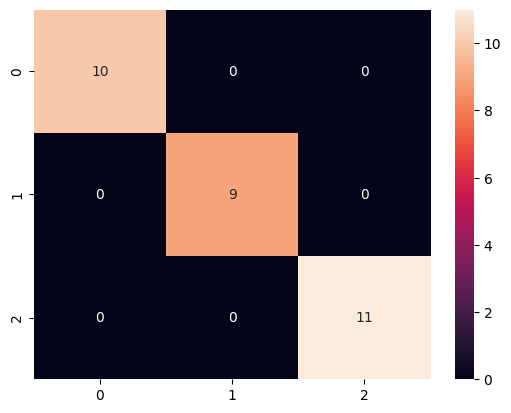

In [30]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True)

6. Model saving

In [31]:
import pickle

In [32]:
# Save the best model
with open('../data/model/logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(grid.best_estimator_, model_file)